## RANDOM forest

### Одно дерево хорошо - много еще лучше

если оч просто, то дерево решений - это модель, которая зачастую склонна к переобучению и с ней приходится бороться: тюнить, настраивать параметры, добиваясь того, что моедль научится вычленять именно общую зависимостm - закономерность (а не частную), и сможет предсказывать точнее, наращивая приэтом точность и полноту предсказаний

Как этого добиваться?

        можно строить несколько деревьев решений для ЧАСТЕЙ данных

Например, мы имеем большую таблицу с огромным числом переменных (v1...v500) , на основании которых мы хотим предсказывать некую величину.

Ок, тогда нужно разбить наш датасэт на куски и для каждого куска построить свое дерево решений

каждое из этих деревьев даст свое предсказание на основании того куска данных, которое мы ему передали

Одним словаом, каждое дерево даст в результате предсказания некую ВЕРОЯТНОСТЬ (р1...р4) отнесения тестовых данных к тому или иному классу

а если взять среднее значение от всех вероятностей, то получится некая МЕГА-вероятность.

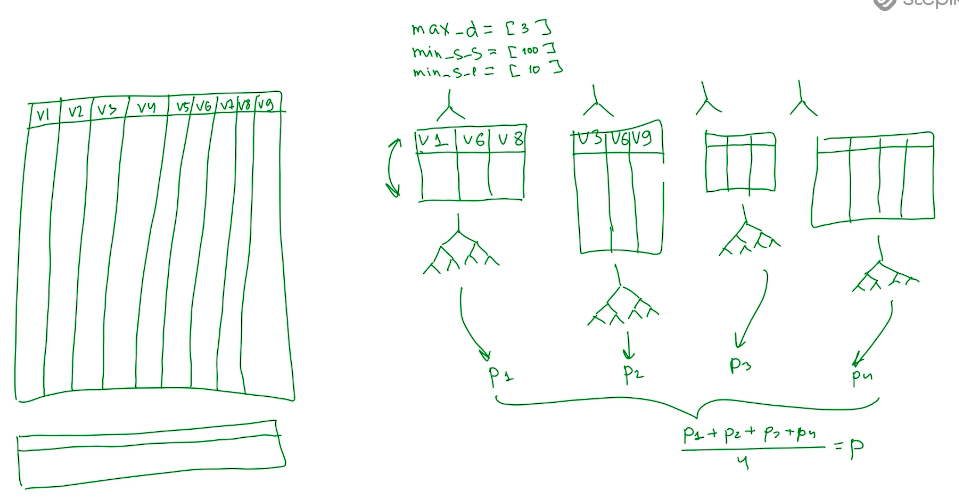

Иными словами, этот набор деревьев, обученных на некоторых кусках одной большой выборки и называется **Random-forest**

**При прочих равных - чем больше деревьев, тем лучше**

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import pandas as pd

зададим число дереьвев и глубину каждого дерева

In [4]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf

RandomForestClassifier(random_state=42)

In [5]:
parametrs = {'n_estimators': range(10,40,10), 'max_depth': [2,5,7,10] }

найдем лучшие параметры

In [6]:
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)

вытащим из сохраненок датасэты по титанику (предобработанные)

In [7]:
X = pd.read_csv('X_titanic.csv')
y = pd.read_csv('y_titanic.csv')

X = X.drop('Unnamed: 0', axis = 1)
y = y.drop('Unnamed: 0', axis = 1)

Вот тут произошла странная штука - pandas подтянул индексы наших id пассажиров в отдельный столбец, и из-за этого модель ниже не захотела нормально обучаться.

        Поэтому после считывания сохраненных датасэтов необходимо 
        - убедиться, что столбец индексов такой, как нам надо
        - если нет - убрать ненужные данные из датасэтов (вообще или в индексы - например для идентификации пассажиров)

#### Итог: придется проделать все итерации по преобразованию исходного файла, иначе модель не заработает!

Обучим наш подборщик моделей на разных параметрах

In [8]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV

 

titanic_data = pd.read_csv('train.csv')

X = titanic_data.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

y = titanic_data.Survived

X = pd.get_dummies(X)

X = X.fillna({'Age': X.Age.median()})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [9]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': range(10, 40, 10)})

In [10]:
grid_search_cv_clf.best_params_

{'max_depth': 7, 'n_estimators': 30}

вытащим лучший лес деревьев (с лучшими подобранными коэффициентами)

In [11]:
best_clf = grid_search_cv_clf.best_estimator_

посчитаем точность такой модели

In [12]:
best_clf.score(X_test,y_test)

0.8067796610169492

посчитаем все остальные метрики:

In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_predicted = best_clf.predict(X_test)

print(f'- Accuracy  (общая точность) модели равна {round(accuracy_score(y_test, y_predicted), 3)}')
print(f'- Precision(точность с учетом ложных срабатываний) модели равна {round(precision_score(y_test, y_predicted), 3)}')
print(f'- Recall    (полнота верных срабатываний) модели равна {round(recall_score(y_test, y_predicted), 3)}')
print(f'- f1_score  (соотношение тоночти и полноты) модели равна {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy  (общая точность) модели равна 0.807
- Precision(точность с учетом ложных срабатываний) модели равна 0.825
- Recall    (полнота верных срабатываний) модели равна 0.667
- f1_score  (соотношение тоночти и полноты) модели равна 0.737


На самом деле точность и полнота (а также их соотношение - f1_score) стали ненамного лучше (см файл ML_titanic), однако:

1) модель леса деревьев использовала для подбора параметров ограниченное число (просто не нашли лучшие, тк плохо искали)
2) модель одного дерева была подкручена на нескольких параметрах (минимальное число сплитов, минимальный размер листика и пр)
3) в модели леса мы оставили многие параметры БЕЗ внимания

        Так что над моделью еще можно поработать, покрутить ее параметры, чтобы повысить метрики точности!

Помимо настройки точности у модели леса деревьев есть еще один вопрос - а как это визуализировать?

как показать, что модель разбивает на классы каким-то понятным образом?

1) Сначала вытащим фичи - те параметры, которые наш обученный классификатор посчитал важными
- здесь поможет команда best_clf.feature_importances_

2) эта команда сама по себе вернет нам просто некий массив np.array со значением фичей, а нам нужно более информативное представление

3) запишем фичи в некоторый датасэт (назовем его feature_importances_df ):
- имена столбцов заберем из имен тренировочного датасэта (в нем как раз хранятся фичи-переменные)
- значения столбцов - как раз дадут нам процент влияния на принятие решения деревом на распил налево-направо при формировании листка
- в сумме значение фичей дают 1 (то есть 100%)

4) на основе этого датасэта с фичами удобно построить такой "пирог" деления важности фичи по ее влиянию на целевую переменную (то есть на разделение классов)

In [14]:
feature_importances_df = pd.DataFrame({'features':list(X_train.columns), 
                                       'feature_importances':  best_clf.feature_importances_})\
                        .sort_values(by='feature_importances', ascending= False)

feature_importances_df

,features,feature_importances
6,Sex_male,0.231671
4,Fare,0.181746
5,Sex_female,0.167101
1,Age,0.154184
0,Pclass,0.123802
2,SibSp,0.041911
3,Parch,0.040980
7,Embarked_C,0.029459
9,Embarked_S,0.016505
8,Embarked_Q,0.012641


Отсортировав значения по убыванию (присвоив параметр ascending = False), vы видим, что наиболее значимый параметр для разделения на классы - это деление по полу 

Кстати, на втором месте идет цена билета, но я уверен, что она прекрасно коррелирует с Классом билета по очевидным причинам

        Разумеется, несоразмерность влияния переменных Sex_female и Sex_male обусловлена тем лишь, что в наши деревья при случайной выборке частей исходного тренировочного датасэта попадали кому-то мужчины, а кому-то женщины. 
        А вообще одну из этих переменных стоило бы исключить для чистоты предсказаний

Предсказания, которые дают модели, это уже хорошо, однако не всегда достаточно. С разными усилиями, мы также можем извлечь важность переменных для осуществления предсказания. Это особенно интересно в науке, где мы пытаемся выявить причинно-следственные связи (хотя, от важности переменных до проверки этих связей ещё длинный путь). Из Decision Tree и Random Forest легко вытащить важность переменных для предсказания, но есть одна особенность. 

        При высокой скореллированности нескольких переменных сплит по любой из них может давать одинаковый Information Gain, и выбор будет сделан случайно. То есть, важность фичей может изменяться в зависимости от выбора из равноценных в процессе обучения. 

#### Поэтому следует смотреть на корреляцию между переменными перед обучением, чтобы лучше представлять данные.

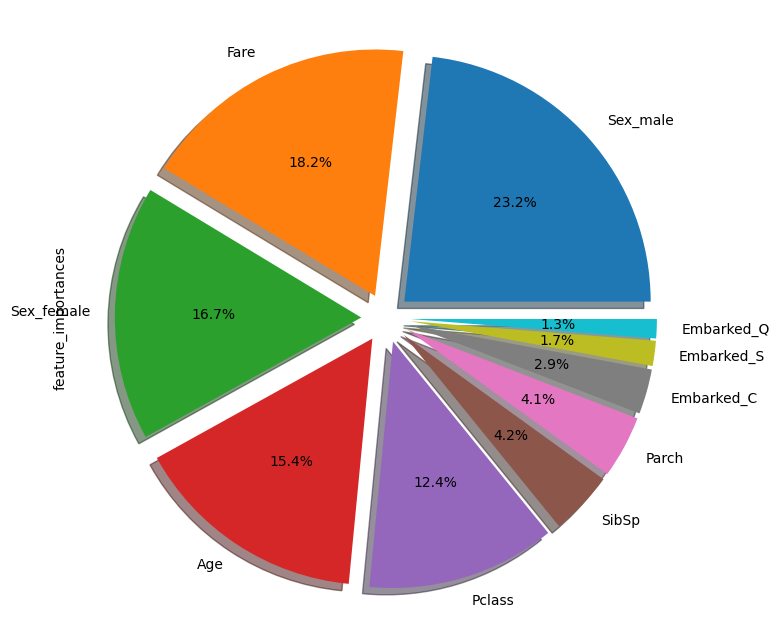

In [15]:

feature_importances_df.plot.pie(
                        explode=[0.1]*len(X_train.columns),
                        labels = feature_importances_df.features,
                        y = 'feature_importances',
                        autopct='%1.1f%%',
                        shadow=True,
                        legend=False,
                        figsize=(8, 8));

Еще один хороший способ визуализировать важность показателей - столбчатая диаграмма (довольно наглядно)

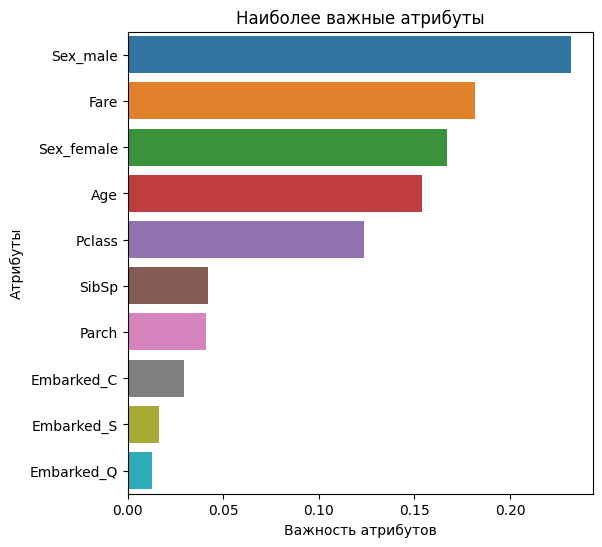

In [16]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=feature_importances_df.features, x=feature_importances_df.feature_importances)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()


### Задача на данные по заболеванию сердца

In [17]:
url = "https://raw.githubusercontent.com/sanyathisside/Predicting-Heart-Disease-using-Machine-Learning/master/heart-disease.csv"

df = pd.read_csv(url)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [18]:
X = df.drop('target', axis = 1)

y = df.target

In [29]:
import numpy as np

np.random.seed(0)
clf_rf_heart = RandomForestClassifier(10, max_depth=5)
clf_rf_heart.fit(X,y)



RandomForestClassifier(max_depth=5, n_estimators=10)

In [30]:
feature_importances_df_heart = pd.DataFrame({'features':list(X.columns), 
                                       'feature_importances':  clf_rf_heart.feature_importances_})\
                        .sort_values(by='feature_importances', ascending= False)

feature_importances_df_heart 

,features,feature_importances
12,thal,0.198525
2,cp,0.139983
7,thalach,0.129550
9,oldpeak,0.116645
11,ca,0.077048
10,slope,0.069208
4,chol,0.056887
3,trestbps,0.053569
8,exang,0.048079
0,age,0.043441


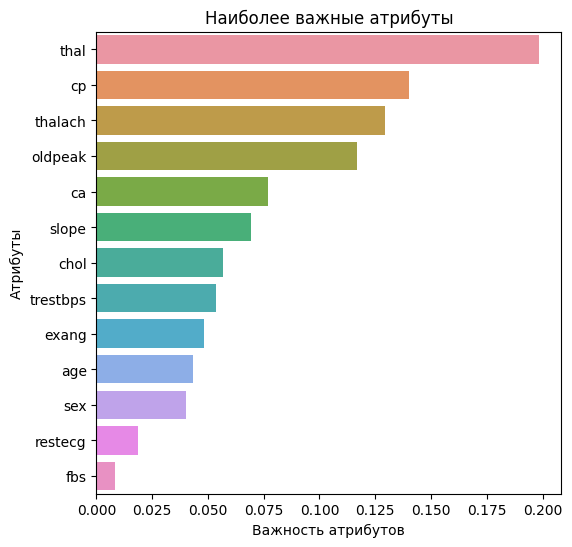

In [31]:
f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y=feature_importances_df_heart.features, x=feature_importances_df_heart.feature_importances)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.show()